# Leonardo Natale - Thesis

[Dixon Coles Paper](http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf)

## Data Cleaning and Manipulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam, lognorm
from scipy.optimize import minimize

results1 = pd.read_csv("results1.csv", index_col=False ,
                       names=["Home", "Away", "4H", "4A", "1H", "1A", "2H", "2A", "3H", "3A"])
results2 = pd.read_csv("results2.csv", index_col=False ,
                       names=["Home", "Away", "4H", "4A", "1H", "1A", "2H", "2A", "3H", "3A"])

In [2]:
results1[results1.isnull().any(axis=1)]

,Home,Away,4H,4A,1H,1A,2H,2A,3H,3A
11,PallMoncalieriSMauro,UraniaBasketMilano,68,88,19,23.0,35.0,45.0,,NaN
15,BasketCecinaASD,BasketGolfoPiombino,62,61,16,16.0,34.0,30.0,NaN,NaN
101,EtruscaBasketSMiniato,OlimpoBasketAlba,88,67,NaN,NaN,NaN,NaN,NaN,NaN
110,SangiorgeseSGiorgioL,FiorentinaBasketScandicci,79,89,,NaN,NaN,NaN,NaN,NaN


In [3]:
results2[results2.isnull().any(axis=1)]

,Home,Away,4H,4A,1H,1A,2H,2A,3H,3A
27,RoburEtFidesVarese,BasketGolfoPiombino,71,78,20,22.0,,NaN,NaN,NaN
28,ValsesiaBasketBorgosesia,MontecatiniBasketball,70,76,NaN,NaN,NaN,NaN,NaN,NaN
30,EtruscaBasketSMiniato,SangiorgeseSGiorgioL,79,68,,NaN,NaN,NaN,NaN,NaN
31,OmniaBasketPavia,FiorentinaBasketScandicci,74,79,,NaN,NaN,NaN,NaN,NaN
45,USEmpoleseASD,FiorentinaBasketScandicci,85,79,NaN,NaN,NaN,NaN,NaN,NaN
47,FulgorOmegna,LibLiburnaBasketLivorno,79,64,NaN,NaN,NaN,NaN,NaN,NaN
76,MontecatiniBasketball,SangiorgeseSGiorgioL,76,66,,NaN,NaN,NaN,NaN,NaN
77,UraniaBasketMilano,OmniaBasketPavia,80,85,NaN,NaN,NaN,NaN,NaN,NaN
111,SangiorgeseSGiorgioL,LibLiburnaBasketLivorno,93,61,33,16.0,50,32.0,NaN,NaN
113,BasketGolfoPiombino,UraniaBasketMilano,78,84,24,19.0,41,41.0,56.0,NaN


I correct a couple of results manually. The scraper could detect the scores.

In [4]:
results2.loc[(results2.Home == "USEmpoleseASD") & (results2.Away == "FiorentinaBasketScandicci"),
             ["1H", "1A", "2H", "2A", "3H", "3A"]] = [25, 19, 40, 39, 62, 58]

results2.loc[(results2.Home == "FulgorOmegna") & (results2.Away == "LibLiburnaBasketLivorno"), 
             ["1H", "1A", "2H", "2A", "3H", "3A"]] = [10, 16, 29, 35, 54, 50]

results2.loc[(results2.Home == "UraniaBasketMilano") & (results2.Away == "OmniaBasketPavia"), 
             ["1H", "1A", "2H", "2A", "3H", "3A"]] = [11, 21, 36, 41, 55, 63]

results2.loc[(results2.Home == "SangiorgeseSGiorgioL") & (results2.Away == "LibLiburnaBasketLivorno"), 
             ["1H", "1A", "2H", "2A", "3H", "3A"]] = [33, 16, 50, 32, 77, 40]

results2.loc[(results2.Home == "BasketGolfoPiombino") & (results2.Away == "UraniaBasketMilano"), 
             ["1H", "1A", "2H", "2A", "3H", "3A"]] = [24, 19, 41, 41, 56, 63]

#### Introducing time difference between every match

There are 16 team, therefore each team plays a total of 30 matches. I assume a game is played every week, for a total of 210 days ~= 7 months, from October to May.

In [5]:
results1["time_diff"] = np.nan
results1.iloc[::8, -1] = np.arange(210, 105, -7)
results1["time_diff"].ffill(inplace=True)

results2["time_diff"] = np.nan
results2.iloc[::8, -1] = np.arange(105, 0, -7)
results2["time_diff"].ffill(inplace=True)

#### Correct a final score

In [6]:
results1.loc[results1["4H"] == 0, "4H"] = 71
results1.loc[results1["4A"] == 0, "4A"] = 83

#### Concatenate the results:

In [7]:
results = pd.concat([results1, results2])

In [8]:
results.dropna(inplace=True)

#### Change the type to integer:

In [9]:
results["4H"] = results["4H"].astype(int, inplace=True)
results["4A"] = results["4A"].astype(int, inplace=True)
results["1H"] = results["1H"].astype(int, inplace=True)
results["1A"] = results["1A"].astype(int, inplace=True)
results["2H"] = results["2H"].astype(int, inplace=True)
results["2A"] = results["2A"].astype(int, inplace=True)
results["3H"] = results["3H"].astype(int, inplace=True)
results["3A"] = results["3A"].astype(int, inplace=True)

#### Reorder the columns:

In [10]:
results = results[['Home', 'Away', '1H', '1A', '2H', '2A', '3H', '3A', '4H', '4A', 'time_diff']]

#### Store Final Score

In [11]:
results.loc[results["4H"] > results["4A"], "FinalScore"] = "H"
results.loc[results["4H"] < results["4A"], "FinalScore"] = "A"

#### Scores Explained:
- 1H means: Points after the first quarter, scored by the home team.
- 1A means: Points after the first quarter, scored by the away team.
- 2H means: Points after the second quarter, scored by the home team.
- 2A means: Points after the second quarter, scored by the away team.
- 3H means: Points after the third quarter, scored by the home team.
- 3A means: Points after the third quarter, scored by the away team.
- 4H means: Total points scored by the home team.
- 4A means: Total points scored by the away team.

#### Now I isolate each quarter score.

For the home team:

In [12]:
results

,Home,Away,1H,1A,2H,2A,3H,3A,4H,4A,time_diff,FinalScore
0,BasketGolfoPiombino,OmniaBasketPavia,13,15,30,28,51,42,65,59,210.0,H
1,OleggioMagicBasket,FulgorOmegna,15,14,33,28,45,46,56,63,210.0,A
2,MontecatiniBasketball,PallMoncalieriSMauro,23,13,46,31,67,42,89,53,210.0,H
3,LibLiburnaBasketLivorno,EtruscaBasketSMiniato,15,12,28,34,47,63,70,72,210.0,A
4,FiorentinaBasketScandicci,BasketCecinaASD,19,20,42,32,61,52,80,75,210.0,H
5,UraniaBasketMilano,ValsesiaBasketBorgosesia,17,20,30,36,47,55,68,79,210.0,A
6,OlimpoBasketAlba,USEmpoleseASD,18,26,37,49,48,64,62,80,210.0,A
7,SangiorgeseSGiorgioL,RoburEtFidesVarese,23,15,52,25,63,32,74,46,210.0,H
8,RoburEtFidesVarese,LibLiburnaBasketLivorno,26,27,58,37,76,60,98,85,203.0,H
9,USEmpoleseASD,OleggioMagicBasket,15,14,31,27,48,48,72,62,203.0,H


In [13]:
results.iloc[:,4:-2:2] = results.iloc[:,4:-2:2] - results.iloc[:,2:7:2].values

For the away team:

In [14]:
results.iloc[:,5:-2:2] = results.iloc[:,5:-2:2] - results.iloc[:,3:8:2].values

In [15]:
results.head()

,Home,Away,1H,1A,2H,2A,3H,3A,4H,4A,time_diff,FinalScore
0,BasketGolfoPiombino,OmniaBasketPavia,13,15,17,13,21,14,14,17,210.0,H
1,OleggioMagicBasket,FulgorOmegna,15,14,18,14,12,18,11,17,210.0,A
2,MontecatiniBasketball,PallMoncalieriSMauro,23,13,23,18,21,11,22,11,210.0,H
3,LibLiburnaBasketLivorno,EtruscaBasketSMiniato,15,12,13,22,19,29,23,9,210.0,A
4,FiorentinaBasketScandicci,BasketCecinaASD,19,20,23,12,19,20,19,23,210.0,H


## Can a Poisson approximate the number of baskets scored each quarter?

1st Quarter:

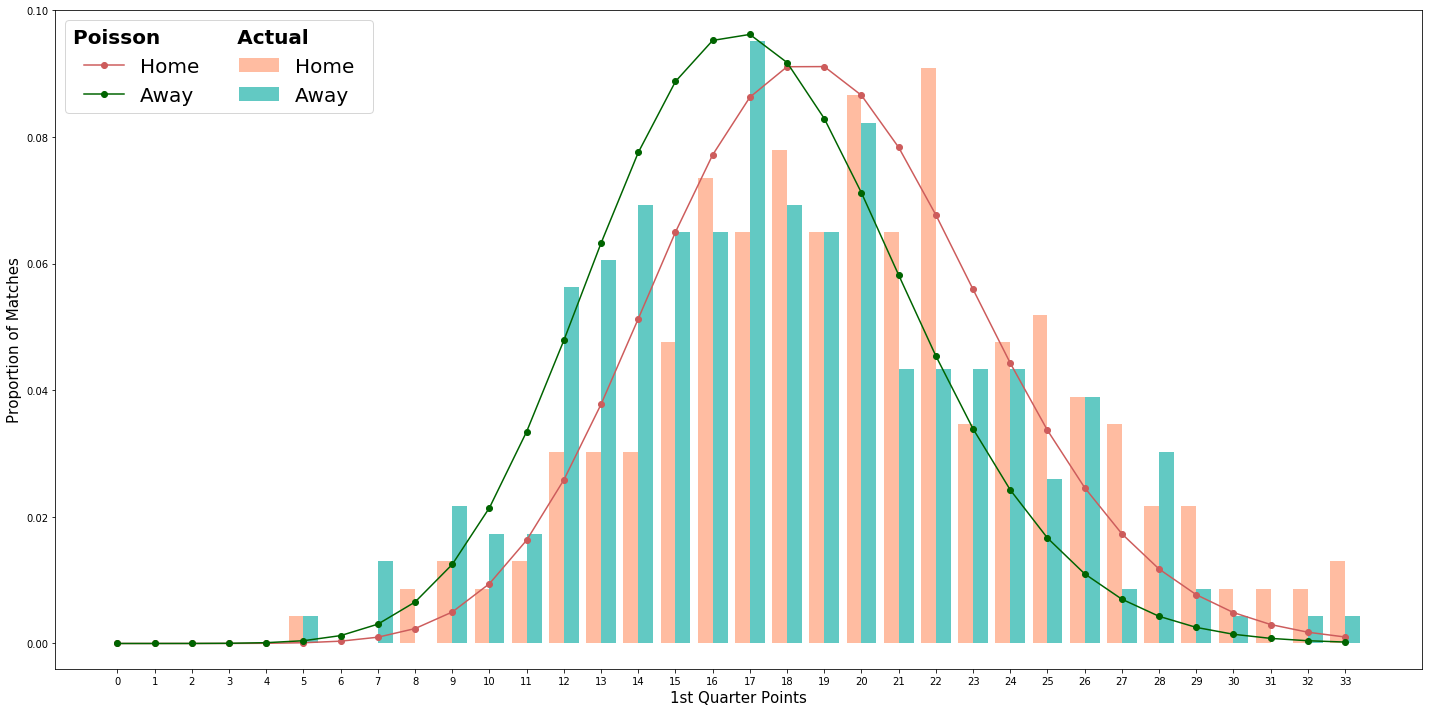

In [16]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 34)] for j in range(0,2)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
plt.hist(results[['1H', '1A']].values, range(0, 34), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 34)],[i for i in range(0, 34)])
plt.xlabel("1st Quarter Points",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.1])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Points_Approx_quarter1.png")
plt.show()

2nd Quarter:

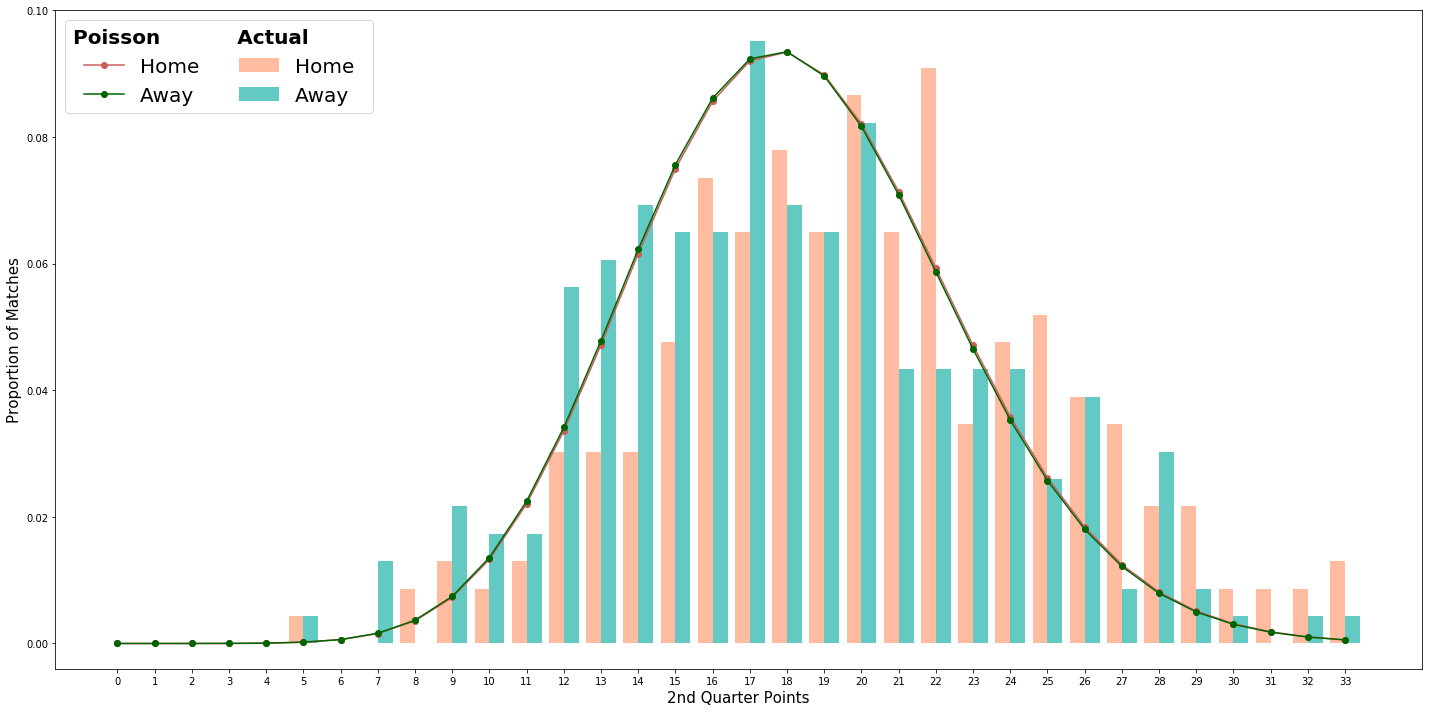

In [17]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 34)] for j in range(2,4)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
plt.hist(results[['1H', '1A']].values, range(0, 34), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 34)],[i for i in range(0, 34)])
plt.xlabel("2nd Quarter Points",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.1])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Points_Approx_quarter2.png")
plt.show()

3rd Quarter:

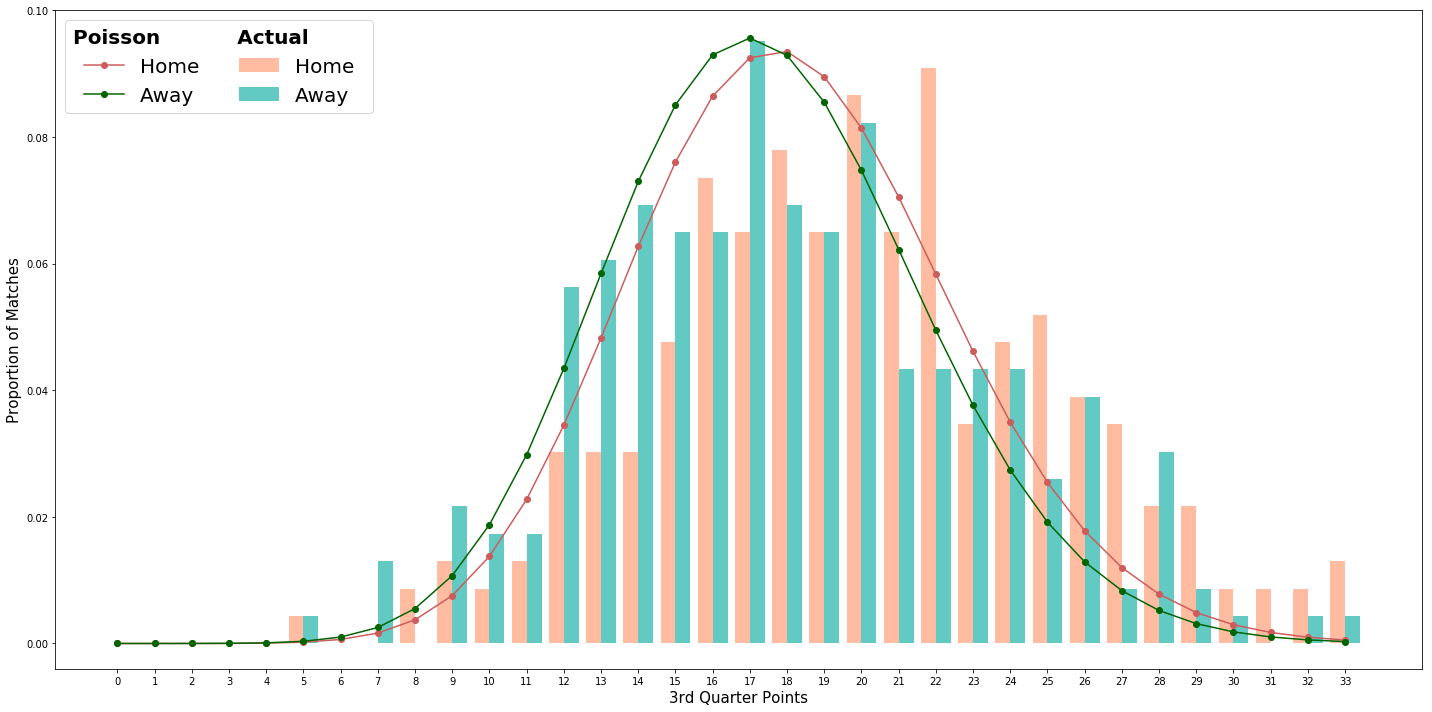

In [18]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 34)] for j in range(4,6)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
plt.hist(results[['1H', '1A']].values, range(0, 34), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 34)],[i for i in range(0, 34)])
plt.xlabel("3rd Quarter Points",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.1])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Points_Approx_quarter3.png")
plt.show()

4th Quarter:

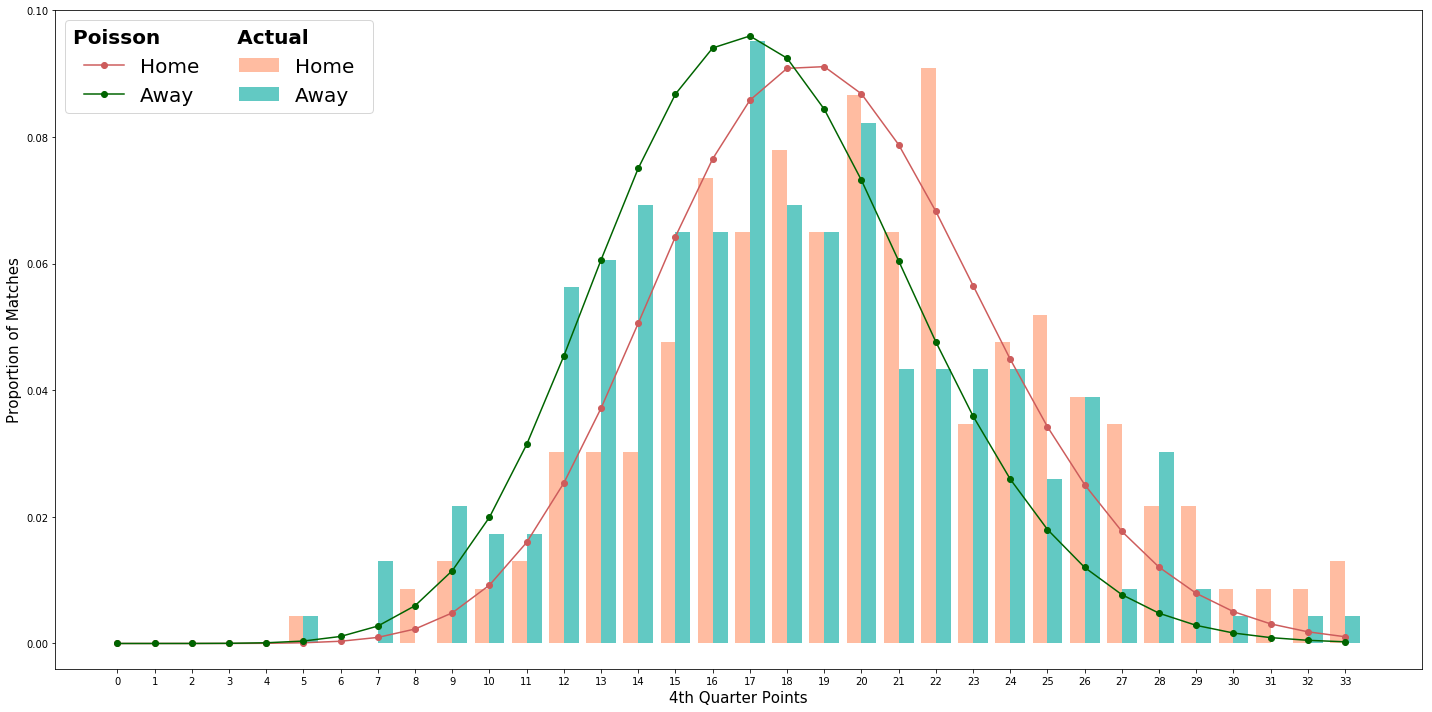

In [19]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 34)] for j in range(6,8)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
n = plt.hist(results[['1H', '1A']].values, range(0, 34), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 34)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 34)],[i for i in range(0, 34)])
plt.xlabel("4th Quarter Points",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.10])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Points_Approx_quarter4.png")
plt.show()

#### As explained in the paper, I divide the number of points by two in order to count the number of baskets scored. Moreover, I subtract 3 because almost no team scores less than 3 basket per quarter.

In [20]:
results.iloc[:, 2:-2] = results.iloc[:, 2:-2] / 2 - 3

$$ \frac{Quarter Points}{2} - 3  $$

1st Quarter:

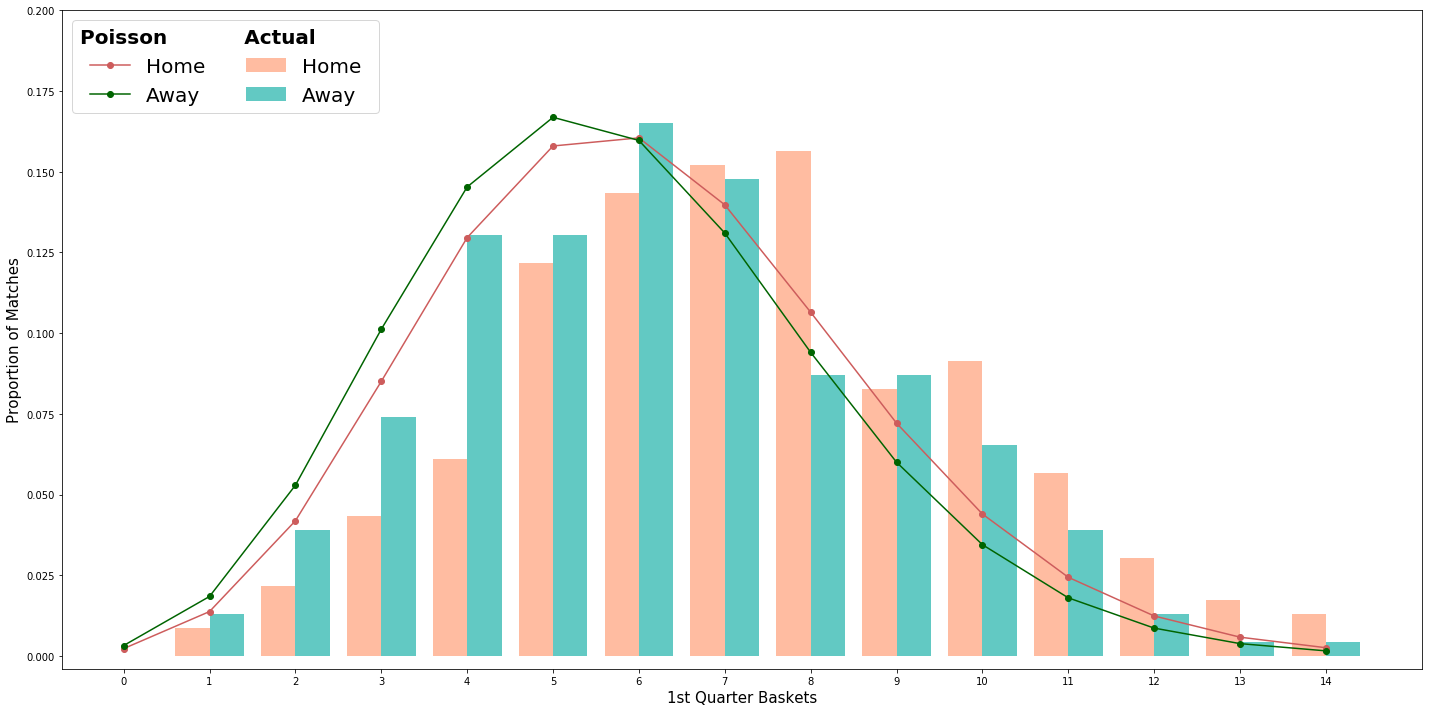

In [21]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 15)] for j in range(4,6)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
n = plt.hist(results[['1H', '1A']].values, range(0, 15), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 15)],[i for i in range(0, 15)])
plt.xlabel("1st Quarter Baskets",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.20])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Baskets_Approx_quarter1.png")
plt.show()

2nd Quarter:

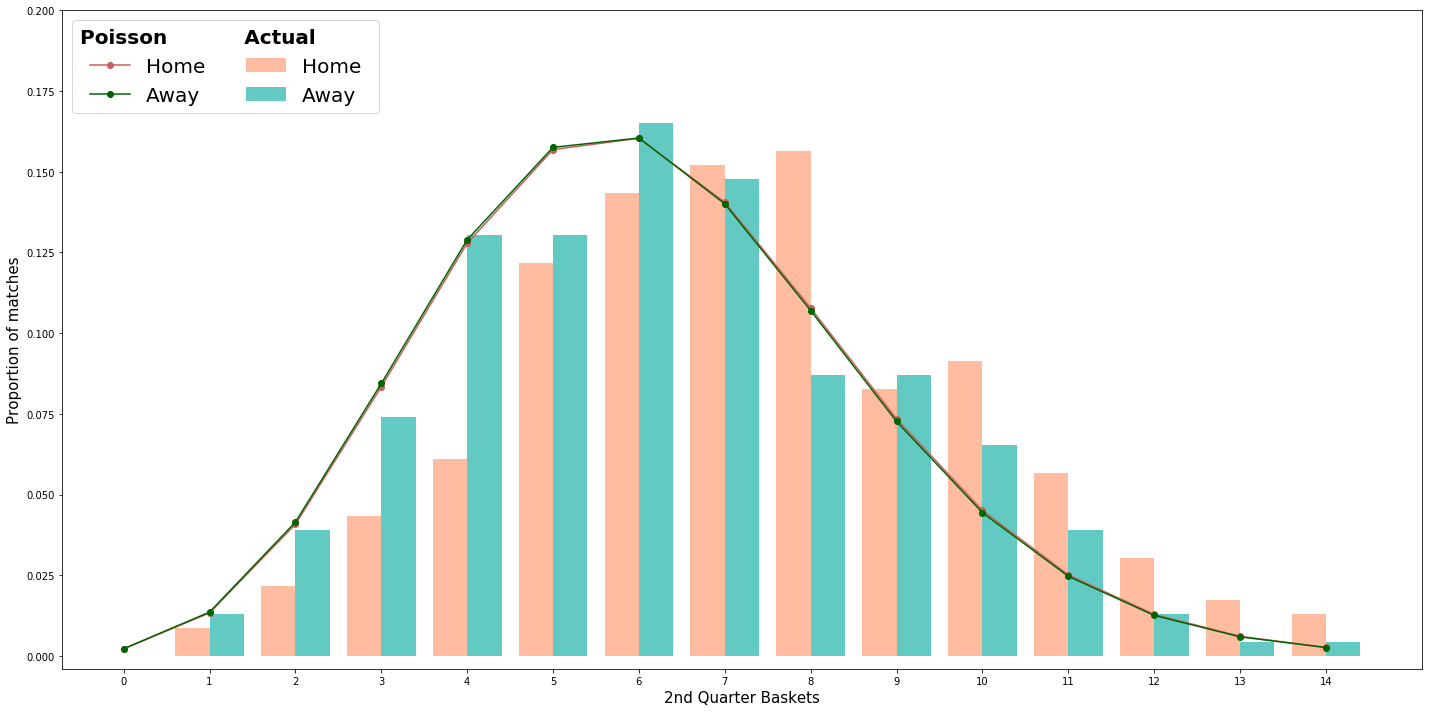

In [22]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 15)] for j in range(2,4)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
plt.hist(results[['1H', '1A']].values, range(0, 15), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 15)],[i for i in range(0, 15)])
plt.xlabel("2nd Quarter Baskets",size=15)
plt.ylabel("Proportion of matches",size=15)
plt.ylim([-0.004, 0.2])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Baskets_Approx_quarter2.png")
plt.show()

3rd Quarter:

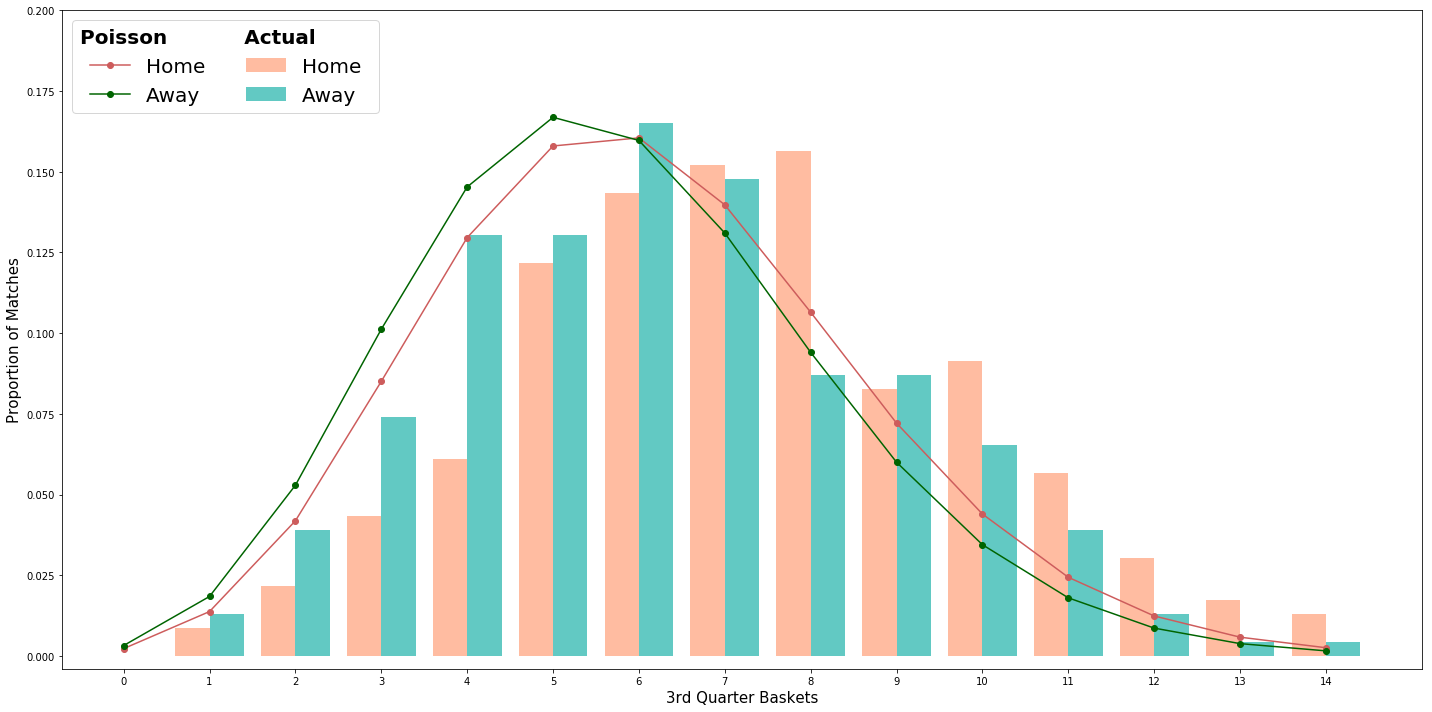

In [23]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 15)] for j in range(4,6)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
plt.hist(results[['1H', '1A']].values, range(0, 15), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 15)],[i for i in range(0, 15)])
plt.xlabel("3rd Quarter Baskets",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.20])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Baskets_Approx_quarter3.png")
plt.show()

4th Quarter:

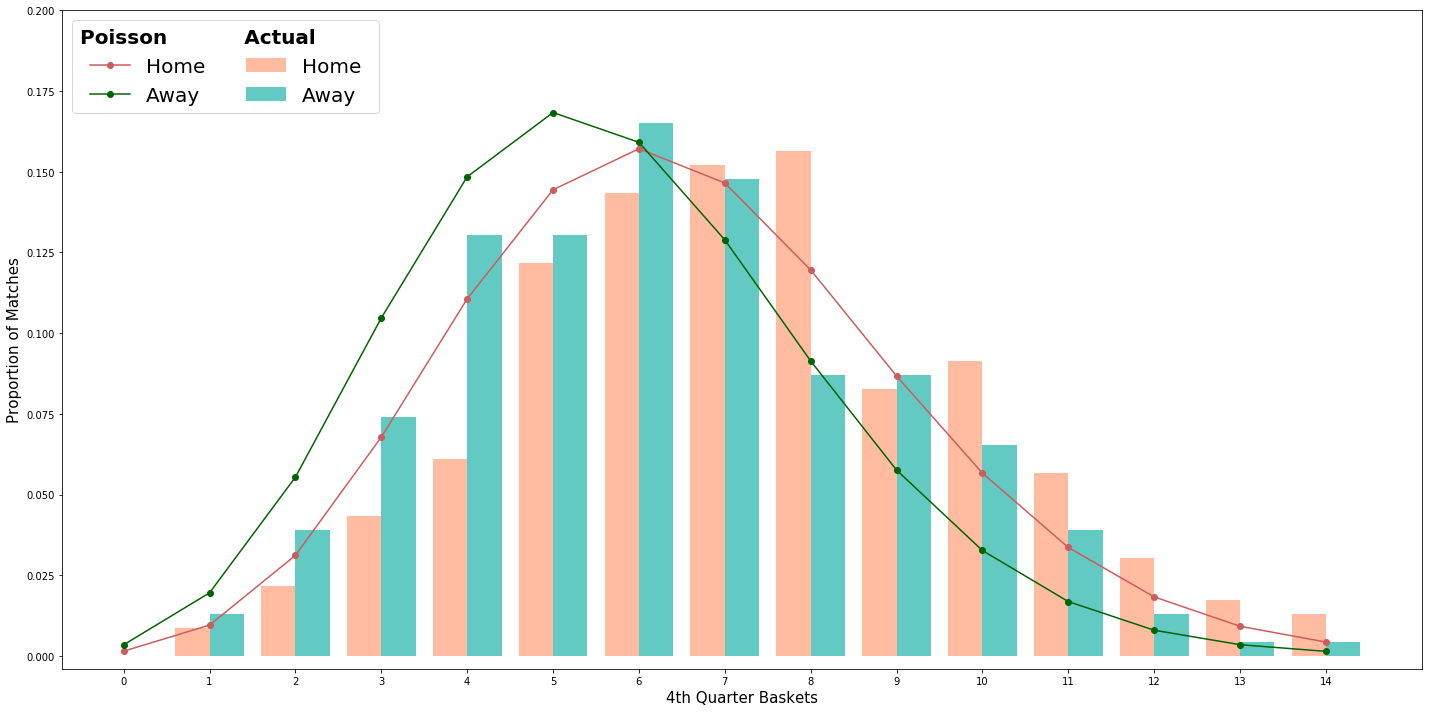

In [24]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(0, 15)] for j in range(6,8)])

fig, ax = plt.subplots(figsize=(20,10))  
# plot histogram of actual goals
n = plt.hist(results[['1H', '1A']].values, range(0, 15), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(0, 15)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper left', prop={'size': 20}, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'20', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(0, 15)],[i for i in range(0, 15)])
plt.xlabel("4th Quarter Baskets",size=15)
plt.ylabel("Proportion of Matches",size=15)
plt.ylim([-0.004, 0.20])
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/Baskets_Approx_quarter4.png")
plt.show()

## Predicting number of baskets scored
    An example, using first quarter data.

First, we need to approximate decimals and set negative numbers to zero.

In [25]:
results.loc[:, "1H"] = np.ceil(results["1H"])
results.loc[:, "1A"] = np.ceil(results["1A"])
results.loc[results["1H"] <= 0, "1H"] = 0
results.loc[results["1A"] <= 0, "1A"] = 0

We can formulate the model in mathematical terms: $$
P\left(X_{i,j} = x, Y_{j,i} = y \right) = \frac{e^{-\lambda} \lambda^x }{x!} \frac{e^{-\mu} \mu^y }{y!}
\\ \text{where } \quad \lambda = \alpha_i \beta_j \gamma \quad \mu = \alpha_j \beta_i
$$

In this equation, $i$ and $j$ refer to the home and away teams, respectively; $\alpha$ and $\beta$ denote each team's attack and defensive strength, respectively, while $\gamma$ represents the home advantage factor. So, we need to calculate $\alpha$ and $\beta$ for each team, as well as $\gamma$ (the home field advantage term- it's the same value for every team).

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

baskets_model_data = pd.concat([results[['Home','Away','1H']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','1H':'baskets'}),
           results[['Away','Home','1A']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','1A':'baskets'})])

poisson_model = smf.glm(formula="baskets ~ home + team + opponent", data=baskets_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                baskets   No. Observations:                  462
Model:                            GLM   Df Residuals:                      430
Model Family:                 Poisson   Df Model:                           31
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1061.6
Date:                Sun, 09 Jun 2019   Deviance:                       467.68
Time:                        10:30:32   Pearson chi2:                     432.
No. Iterations:                     4   Covariance Type:             nonrobust
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 1.9772      0.104     19.059      0

Example of a game:

In [29]:
poisson_model.predict(pd.DataFrame(data={'team': 'RoburEtFidesVarese', 'opponent': 'FiorentinaBasketScandicci',
                                       'home':1},index=[1]))

1    4.792651
dtype: float64

In [30]:
poisson_model.predict(pd.DataFrame(data={'team': 'FiorentinaBasketScandicci', 'opponent': 'RoburEtFidesVarese',
                                       'home':0},index=[1]))

1    6.778332
dtype: float64

In [32]:
def simulate_match(basket_model, homeTeam, awayTeam, max_baskets=14):
    home_baskets_avg = basket_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_baskets_avg = basket_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_baskets+1)] for team_avg in [home_baskets_avg, away_baskets_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
match = simulate_match(poisson_model, 'RoburEtFidesVarese', 'FiorentinaBasketScandicci', max_baskets=14)

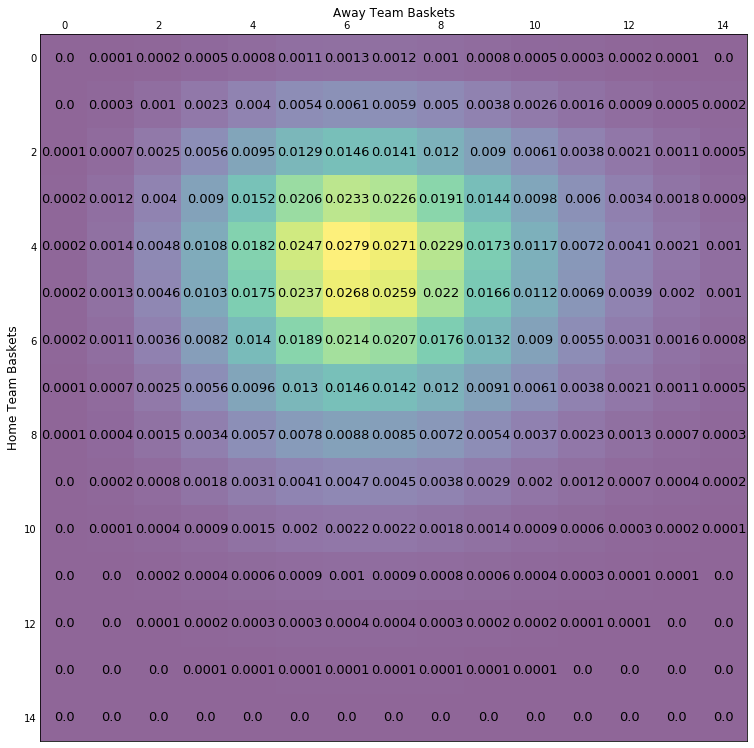

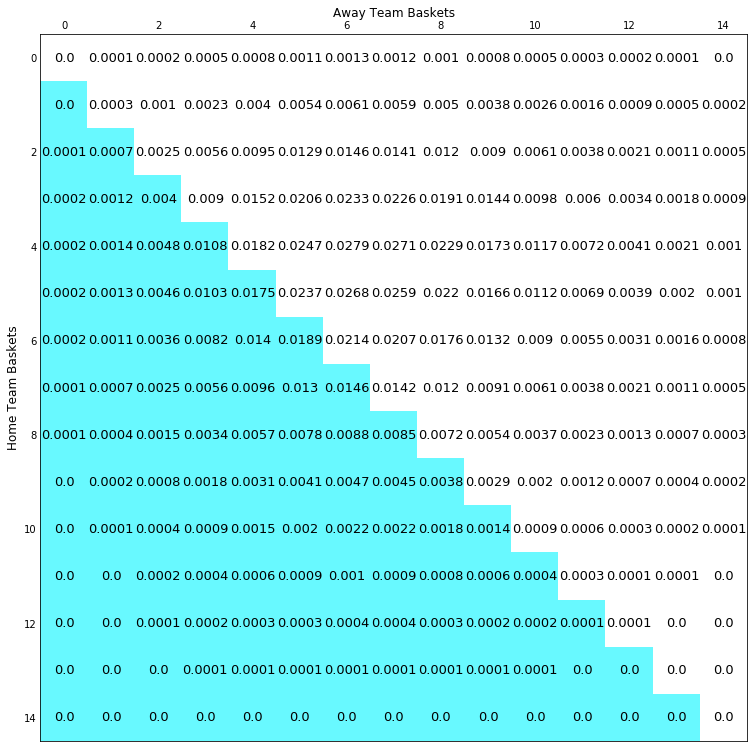

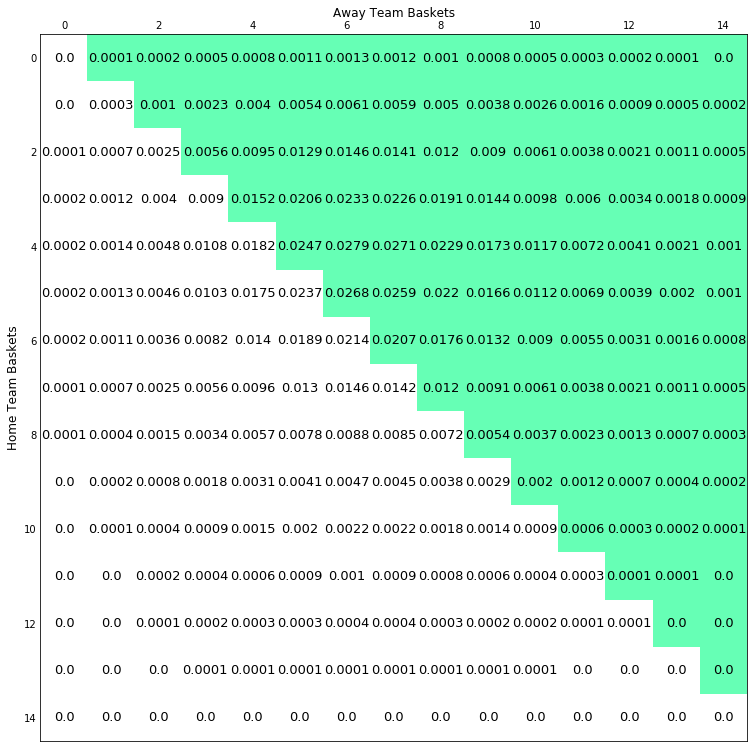

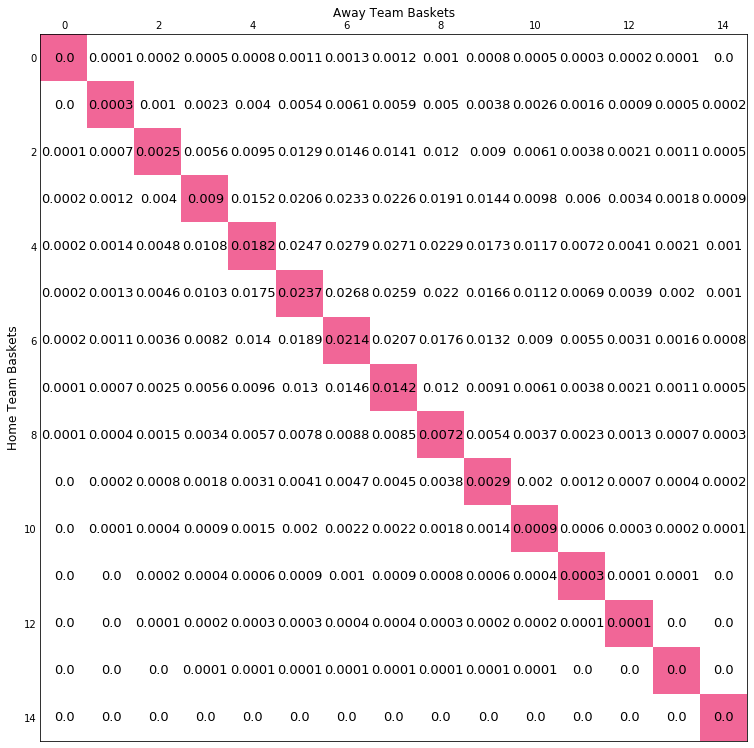

In [33]:
from matplotlib.colors import ListedColormap

def matrix_gif(matrix, colour_matrix, colour_map, title="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(13,13))
    if heatmap:
        ax1.matshow(matrix, alpha=alpha)
    else:
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel('Away Team Baskets', fontsize=12)
    ax1.set_ylabel('Home Team Baskets', fontsize=12)
    ax1.xaxis.set_label_position('top')
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i][j]
            ax1.text(j, i, str(round(c,4)), va='center', ha='center', size=13)
    plt.figtext(0.5, 0.05, title, horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
    return fig

cmap = ListedColormap(['w', '#04f5ff', '#00ff85', '#e90052'])
matrix = simulate_match(poisson_model, 'RoburEtFidesVarese', 'FiorentinaBasketScandicci', max_baskets=14)
matn = len(matrix)
matrix_gif(matrix, matrix, ListedColormap(['w']), heatmap=True, 
           alpha=0.6).savefig("../Tesi_Pdf/foto/match_matrix_0.png")
plt.show()

for t,(mat,colour) in enumerate(zip([np.tril(np.ones((matn,matn)),-1),
                            np.triu(np.ones((matn,matn))*2,1), np.diag([3]*matn),
                                             np.array([0 if i+j<3 else 1 for i in range(matn) for j in range(matn)]).reshape(matn,matn)],
                          ['#04f5ff', '#00ff85', '#e90052'])):
    matrix_gif(matrix, mat, ListedColormap(['w'] + [colour]), heatmap=False, 
               alpha=0.6).savefig("../Tesi_Pdf/foto/match_matrix_{}.png".format(t+1))
    plt.show()

Draw Probability:

In [34]:
np.trace(match)

0.10067336504683916

Away Team Wins:

In [35]:
np.triu(match).sum()-np.trace(match)

0.664197764893085

Home Team Wins:

In [36]:
np.tril(match).sum()-np.trace(match)

0.2306746668320384

## Introducing Time Decay Model

Two weighting options offered in the Dixon-Coles paper are illustrated below:

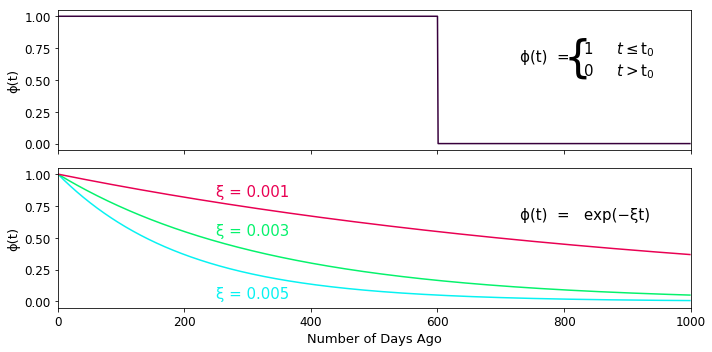

In [37]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(range(1000), [0 if y >600 else 1 for y in range(1000)], label='Component 1', color='#38003c', marker='')
ax2.plot(range(1000), np.exp([y*-0.005 for y in range(1000)]), label='Component 1', color='#07F2F2', marker='')
ax2.plot(range(1000), np.exp([y*-0.003 for y in range(1000)]), label='Component 1', color='#05F26C', marker='')
ax2.plot(range(1000), np.exp([y*-0.001 for y in range(1000)]), label='Component 1', color='#e90052', marker='')

ax1.set_ylim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax1.set_xlim([-0.5,1000])
ax2.set_xlim([-0.5,1000])
ax1.set_xticklabels([])
ax2.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_xlabel("Number of Days Ago",size=13)
ax1.set_ylabel("ϕ(t)",size=13)
ax2.set_ylabel("ϕ(t)",size=13)
ax1.text(830, 0.5, '1     $t \leq \mathregular{t_0}$\n0     $t > \mathregular{t_0}$',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax1.text(800, 0.5, '{',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=44)
ax1.text(730, 0.62, 'ϕ(t)  = ',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax2.text(730, 0.62, 'ϕ(t)  =   exp(−ξt)',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax2.text(250, 0.8, 'ξ = 0.001',
        verticalalignment='bottom', horizontalalignment='left',
        color='#e90052', fontsize=15)
ax2.text(250, 0.5, 'ξ = 0.003',
        verticalalignment='bottom', horizontalalignment='left',
        color='#05F26C', fontsize=15)
ax2.text(250, 0.0, 'ξ = 0.005',
        verticalalignment='bottom', horizontalalignment='left',
        color='#07F2F2', fontsize=15)
plt.tight_layout()
plt.savefig("../Tesi_Pdf/foto/DecayFunctions.png")

The first option forces the model to only consider matches within some predefined period (e.g. since the start of the season), while the negative exponential downweights match results more strongly going further into the past. The refined model can be written in these mathematical terms:

$$
L(\alpha_i, \beta_i, \rho, \gamma, i=1,\dots,n) = \prod_{k \in A_t}\{\tau_{\lambda_k,\mu_k}(x_k, y_k) \frac{e^{-\lambda} \lambda^{x_k} }{x_k!} \frac{e^{-\mu} \mu^{y_k} }{y_k!}\}^{\phi(t-t_k)}
$$
where $t_k$ represents the time that match $k$ was played,  $A_t = \{k: t_k < t\}$ (i.e. set of matches played before time $t$), $\alpha$, $\beta$, $\gamma$ and $\tau$ are defined as before. $\phi$ represents the non-increasing weighting function. Copying the original Dixon Coles paper, we'll set $\phi(t)$ to be a negative exponential with rate $\xi$ (called xi). As before, we need to determine the parameters that maximise this likelihood function. We can't just feed this equation into a minimisation algorithm for various reasons (e.g. we can trivially maximise this function by increasing $\xi$). Instead, we'll fix $\xi$ and determine the remaining parameters the same way as before.
Note how $\xi$=0 equates to the standard non-time weighted log-likelihood function.

We need to adjust our dataframe to include columns that represent the number of days since the completion of that game as well as the match result (home, away or draw).

#### Store who wins each quarter:

In [38]:
results.loc[results["1H"] > results["1A"], "Score1"] = "H"
results.loc[results["1H"] < results["1A"], "Score1"] = "A"
results.loc[results["1H"] == results["1A"], "Score1"] = "D"

results.loc[results["2H"] > results["2A"], "Score2"] = "H"
results.loc[results["2H"] < results["2A"], "Score2"] = "A"
results.loc[results["2H"] == results["2A"], "Score2"] = "D"

results.loc[results["3H"] > results["3A"], "Score3"] = "H"
results.loc[results["3H"] < results["3A"], "Score3"] = "A"
results.loc[results["3H"] == results["3A"], "Score3"] = "D"

results.loc[results["4H"] > results["4A"], "Score4"] = "H"
results.loc[results["4H"] < results["4A"], "Score4"] = "A"
results.loc[results["4H"] == results["4A"], "Score4"] = "D"

With this dataframe, we're now ready to compare different values of $\xi$.

Here's an example of how you would build a model for a given value of $\xi$.

In [39]:
def solve_parameters_decay(dataset, xi=0.001, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:15])-15}] , **kwargs):
    teams = np.sort(dataset['Home'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['Away'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("something not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([1]) )) # gamma (home advantage)
        
    def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, gamma, t, xi=xi):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return  np.exp(-xi*t) * (np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_parameters(params):  # minimize gives init_vals to this function
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        gamma = params[-1]
        log_like = [dc_log_like_decay(row._3, row._4, score_coefs[row.Home], defend_coefs[row.Home],
                                      score_coefs[row.Away], defend_coefs[row.Away], 
                                      gamma, row.time_diff, xi=xi) for row in dataset.itertuples()]
        return -sum(log_like)
    
    opt_output = minimize(estimate_parameters, init_vals, options=options, constraints = constraints)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['home_adv'],
                        opt_output.x))

Example with one quarter:

In [40]:
dataset = results[['Home', 'Away', '1H', '1A','Score1', 'time_diff']].copy()
dataset.head()

,Home,Away,1H,1A,Score1,time_diff
0,BasketGolfoPiombino,OmniaBasketPavia,4.0,5.0,A,210.0
1,OleggioMagicBasket,FulgorOmegna,5.0,4.0,H,210.0
2,MontecatiniBasketball,PallMoncalieriSMauro,9.0,4.0,H,210.0
3,LibLiburnaBasketLivorno,EtruscaBasketSMiniato,5.0,3.0,H,210.0
4,FiorentinaBasketScandicci,BasketCecinaASD,7.0,7.0,D,210.0


Solve for this value of $\xi$

In [41]:
params_xi= solve_parameters_decay(dataset, xi=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:501: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1061.6152433242676
            Iterations: 35
            Function evaluations: 1289
            Gradient evaluations: 35


In [42]:
params_xi

{'attack_BasketCecinaASD': 1.1058351756135363,
 'attack_BasketGolfoPiombino': 1.1113867790574512,
 'attack_EtruscaBasketSMiniato': 0.9601873324309701,
 'attack_FiorentinaBasketScandicci': 1.1528951849389335,
 'attack_FulgorOmegna': 1.0742785674785982,
 'attack_LibLiburnaBasketLivorno': 0.8666006215610303,
 'attack_MontecatiniBasketball': 1.0551354556543622,
 'attack_OleggioMagicBasket': 1.0427038111712243,
 'attack_OlimpoBasketAlba': 0.8922084598852632,
 'attack_OmniaBasketPavia': 1.0365713956331462,
 'attack_PallMoncalieriSMauro': 0.819426556182192,
 'attack_RoburEtFidesVarese': 0.6215907032046336,
 'attack_SangiorgeseSGiorgioL': 1.0332518019654835,
 'attack_USEmpoleseASD': 1.0533226462631744,
 'attack_UraniaBasketMilano': 1.1746055089599998,
 'attack_ValsesiaBasketBorgosesia': 1.0641678979129028,
 'defence_BasketCecinaASD': 0.8713612971140658,
 'defence_BasketGolfoPiombino': 0.8315861792446158,
 'defence_EtruscaBasketSMiniato': 0.7563461158730962,
 'defence_FiorentinaBasketScandicci'

To determine the optimal value of $\xi$, we'll select the model that makes the best predictions. Repeating the process in the Dixon-Coles paper, rather working on quarter score predictions, the models will be assessed on quarter result predictions. Essentially, the model that predicted the actual quarter results with the highest probability will be deemed the winner. 
We can redefine the objective in mathematical terms; we wish to find $\xi$ that maximises $S(\xi)$:

$$
S(\xi) = \sum^{N}_{k=1} (\delta^{H}_{k} \log p^{H}_{k} + \delta^{A}_{k} \log p^{A}_{k} + \delta^{D}_{k} \log p^{D}_{k})
$$

The $\delta$ terms just captures the match result e.g. $\delta^{H}_{k}$ = 1 if quarter $k$ ended in a home win, while the $p$ terms are simply the quarter result probabilities. For example, we can rewrite $p^{H}_{k}$ (probability of home win):

$$
p^{H}_{k} = \sum_{l,m \in B_H} P(X_k = l, Y_k = m), \text{ where } B_H = \{(l,m): l>m\}
$$
Each of these $p$ terms translates to the matrix operations outlined previously. One part that will change is the log likelihood function.

To assess the predictive accuracy of the model, we'll utilise an approach analogous to the validation set in machine learning. We use all of the previous results in that season to build a model. We determine how that model predicted the actual results of the quarter with the above equations. We move onto the next set of first quarters and build the model again and assess how well it predicted the results of those quarters. We repeat this process for the rest of the 2017/18 season. When we sum up all of these predictions, you have calculated what is called the predicted profile log-likelihood for that value of $\xi$.

In [43]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_baskets=14):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_baskets+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    return output_matrix

def get_1x2_probs(match_score_matrix):
    """From the matrix of probabilities we return home win, away wins, draw percentages. 
    """
    return dict({"H":np.sum(np.tril(match_score_matrix, -1)),  # home wins quarter
                 "A":np.sum(np.triu(match_score_matrix, 1)),   # away wins quarter
                 "D":np.sum(np.diag(match_score_matrix))})     # draw

def build_temp_model(dataset, time_diff, xi=0.000, init_params=None):
    """Get a smaller dataset up to the date we are interested in.
    """
    test_dataset = dataset[dataset['time_diff']<=time_diff]
    if len(test_dataset)==0:
        return 0
    train_dataset = dataset[dataset['time_diff']>time_diff]
    train_dataset.loc[:,'time_diff'] = train_dataset['time_diff'] - time_diff
    params = solve_parameters_decay(train_dataset, xi=xi, init_vals=init_params)
    predictive_score = sum([np.log(get_1x2_probs(dixon_coles_simulate_match(
                    params, row.Home, row.Away))[row.Score1]) for row in test_dataset.itertuples()])
    return predictive_score    
    
def check_xi(match_day):
    xi_score = build_temp_model(dataset, match_day, xi=my_xi)
    return xi_score

In [44]:
xi_vals = [0.0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0016, 0.0018, 
            0.002, 0.0025, 0.003, 0.0035,  0.0035, 0.004,  0.0045, 0.005]

match_days = np.arange(35, 0, -7)

In [45]:
from multiprocessing import Pool
xi_result = []
for my_xi in xi_vals:
    with Pool() as pool:         # start worker processes (number will depend on your computer's architecture)
        xi_result.append(pool.map(check_xi, match_days))

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 942.9486242590484
            Iterations: 40
            Function evaluations: 1465
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1020.9506032894279
            Iterations: 40
            Function evaluations: 1468
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 981.9161438411317
            Iterations: 41
            Function evaluations: 1505
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 870.025732145498
            Iterations: 40
            Function evaluations: 1467
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 903.5662629769632
            Iterations: 45
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 962.2067083894641
            Iterations: 32
            Function evaluations: 1175
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 886.5037431368528
            Iterations: 39
            Function evaluations: 1430
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 999.8418596188468
            Iterations: 39
            Function evaluations: 1431
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 854.2268079466322
            Iterations: 40
            Function evaluations: 1465
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 924.5662062055181
            Iterations: 40
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 943.0111545363817
            Iterations: 42
            Function evaluations: 1540
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 906.6460019076633
            Iterations: 42
            Function evaluations: 1538
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 979.302413612853
            Iterations: 43
            Function evaluations: 1574
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 838.7969490893712
            Iterations: 41
            Function evaluations: 1502
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 869.8551991612493
            Iterations: 43
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 889.1750015120537
            Iterations: 37
            Function evaluations: 1355
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 959.3150745033029
            Iterations: 29
            Function evaluations: 1065
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 823.7265214803498
            Iterations: 44
            Function evaluations: 1611
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 924.3144700676409
            Iterations: 40
            Function evaluations: 1468
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 853.6094051395735
            Iterations: 44
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 872.1405771203086
            Iterations: 37
            Function evaluations: 1355
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 906.102113436545
            Iterations: 42
            Function evaluations: 1540
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 939.8631324531001
            Iterations: 46
            Function evaluations: 1684
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 809.0061597852412
            Iterations: 43
            Function evaluations: 1573
            Gradient evaluations: 43
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.7554499527375
            Iterations: 43
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 888.3599951249937
            Iterations: 36
            Function evaluations: 1321
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 794.6267550094847
            Iterations: 44
            Function evaluations: 1608
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 822.2827414652998
            Iterations: 44
            Function evaluations: 1611
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 855.5304706949811
            Iterations: 37
            Function evaluations: 1356
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 920.930503906932
            Iterations: 39
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 807.1809900371637
            Iterations: 40
            Function evaluations: 1466
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 839.3328047918092
            Iterations: 44
            Function evaluations: 1611
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 902.5015613711751
            Iterations: 42
            Function evaluations: 1538
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 780.5794559400856
            Iterations: 39
            Function evaluations: 1429
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 871.0744547048831
            Iterations: 42
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 854.2322658825789
            Iterations: 38
            Function evaluations: 1393
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 823.5360613721931
            Iterations: 40
            Function evaluations: 1468
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 766.8556447873126
            Iterations: 44
            Function evaluations: 1608
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 792.4402031184744
            Iterations: 39
            Function evaluations: 1430
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 884.5611971469292
            Iterations: 39
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 808.1290599868984
            Iterations: 36
            Function evaluations: 1321
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 867.0947797731882
            Iterations: 35
            Function evaluations: 1283
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 778.0506733570477
            Iterations: 44
            Function evaluations: 1611
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 753.4469595242806
            Iterations: 42
            Function evaluations: 1539
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 837.8206010931596
            Iterations: 42
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 850.0881486091267
            Iterations: 35
            Function evaluations: 1283
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 821.8270336557744
            Iterations: 42
            Function evaluations: 1538
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 793.1009224392327
            Iterations: 44
            Function evaluations: 1606
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 764.0029751108145
            Iterations: 40
            Function evaluations: 1465
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 740.3452503238565
            Iterations: 44
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 750.2879500295387
            Iterations: 36
            Function evaluations: 1319
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 727.5426072771521
            Iterations: 44
            Function evaluations: 1607
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 778.441150181494
            Iterations: 44
            Function evaluations: 1610
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 833.5275988214298
            Iterations: 35
            Function evaluations: 1283
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 806.2395194847027
            Iterations: 45
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 793.9917666598006
            Iterations: 35
            Function evaluations: 1282
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 743.3369841997524
            Iterations: 42
            Function evaluations: 1538
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 717.3980835494093
            Iterations: 44
            Function evaluations: 1609
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 768.971503656744
            Iterations: 35
            Function evaluations: 1282
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 696.7944026296003
            Iterations: 43
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 733.9964982241082
            Iterations: 35
            Function evaluations: 1283
            Gradient evaluations: 35
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 756.9660328167784
            Iterations: 38
            Function evaluations: 1393
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 710.3205191156119
            Iterations: 45
            Function evaluations: 1648
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 667.753187678451
            Iterations: 44
            Function evaluations: 1609
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 686.4003360393251
            Iterations: 44
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 679.2512006081391
            Iterations: 38
            Function evaluations: 1394
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 657.1717349378807
            Iterations: 42
            Function evaluations: 1538
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 640.3120344392505
            Iterations: 44
            Function evaluations: 1610
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 722.2694673709826
            Iterations: 34
            Function evaluations: 1246
            Gradient evaluations: 34
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 701.1546575734801
            Iterations: 40
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 640.3120344392505
            Iterations: 44
            Function evaluations: 1610
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 657.1717349378807
            Iterations: 42
            Function evaluations: 1538
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 701.1546575734801
            Iterations: 40
            Function evaluations: 1463
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 722.2694673709826
            Iterations: 34
            Function evaluations: 1246
            Gradient evaluations: 34
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 679.2512006081391
            Iterations: 38
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 670.2980198991119
            Iterations: 36
            Function evaluations: 1319
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 629.5978511890105
            Iterations: 42
            Function evaluations: 1537
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 614.3711710457504
            Iterations: 44
            Function evaluations: 1610
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 649.998604536224
            Iterations: 41
            Function evaluations: 1501
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 689.7350994373257
            Iterations: 45
            Funct

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 659.2087998051126
            Iterations: 31
            Function evaluations: 1139
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 589.8374836493251
            Iterations: 38
            Function evaluations: 1393
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 641.2896229385805
            Iterations: 41
            Function evaluations: 1500
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 622.4416754012021
            Iterations: 38
            Function evaluations: 1393
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 603.5721838401579
            Iterations: 42
            Func

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 630.5481923506732
            Iterations: 37
            Function evaluations: 1356
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 566.6240460351717
            Iterations: 44
            Function evaluations: 1610
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 596.4680172195084
            Iterations: 40
            Function evaluations: 1464
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 578.9955869582086
            Iterations: 42
            Function evaluations: 1536
            Gradient evaluations: 42
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 614.0026735011843
            Iterations: 41
            Func

In [46]:
xi_scores = []
for a in xi_result:
    xi_scores.append(sum(a))

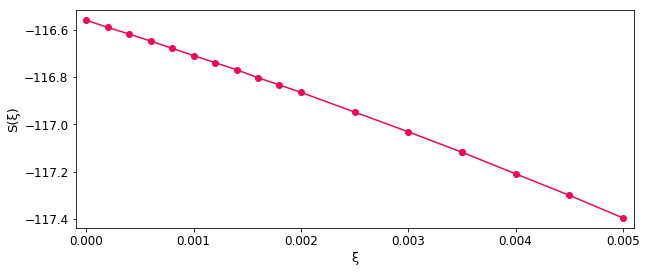

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(xi_vals, xi_scores, label='Component 1', color='#F2055C', marker='o')
# ax1.set_ylim([-126.20, -125.20])
ax1.set_xlim([-0.0001,0.0051])
#ax1.set_xticklabels([])
ax1.set_ylabel('S(ξ)', fontsize=13)
ax1.set_xlabel('ξ', fontsize=13)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
plt.savefig("../Tesi_Pdf/foto/Predictive_Profile_Log_Likelihood.png")
plt.show()

It seems that $S(\xi)$ is minimised at $\xi$=0 (remember that $\xi \geq 0$), which is simply the standard non-weighted DC model. I suppose this makes sense: If you only have data for the season in question, then you don't have the luxury of down-weighting older results. In the Dixon-Coles paper, they actually compiled data from 4 consecutive seasons (1992/93 to 95/96). You'd expect time weighting to become more effective as the timeframe of your data expands. In other words, the first game of the same season might well be valuable, but the first game of the season five years ago is presumably less valuable.

## Prediction

In [48]:
training = results.iloc[:-24, :]
test = results.iloc[-24:, :]

In [49]:
training

,Home,Away,1H,1A,2H,2A,3H,3A,4H,4A,time_diff,FinalScore,Score1,Score2,Score3,Score4
0,BasketGolfoPiombino,OmniaBasketPavia,4.0,5.0,5.5,3.5,7.5,4.0,4.0,5.5,210.0,H,A,H,H,A
1,OleggioMagicBasket,FulgorOmegna,5.0,4.0,6.0,4.0,3.0,6.0,2.5,5.5,210.0,A,H,H,A,A
2,MontecatiniBasketball,PallMoncalieriSMauro,9.0,4.0,8.5,6.0,7.5,2.5,8.0,2.5,210.0,H,H,H,H,H
3,LibLiburnaBasketLivorno,EtruscaBasketSMiniato,5.0,3.0,3.5,8.0,6.5,11.5,8.5,1.5,210.0,A,H,A,A,H
4,FiorentinaBasketScandicci,BasketCecinaASD,7.0,7.0,8.5,3.0,6.5,7.0,6.5,8.5,210.0,H,D,H,A,A
5,UraniaBasketMilano,ValsesiaBasketBorgosesia,6.0,7.0,3.5,5.0,5.5,6.5,7.5,9.0,210.0,A,A,A,A,A
6,OlimpoBasketAlba,USEmpoleseASD,6.0,10.0,6.5,8.5,2.5,4.5,4.0,5.0,210.0,A,A,A,A,A
7,SangiorgeseSGiorgioL,RoburEtFidesVarese,9.0,5.0,11.5,2.0,2.5,0.5,2.5,4.0,210.0,H,H,H,H,A
8,RoburEtFidesVarese,LibLiburnaBasketLivorno,10.0,11.0,13.0,2.0,6.0,8.5,8.0,9.5,203.0,H,A,H,A,A
9,USEmpoleseASD,OleggioMagicBasket,5.0,4.0,5.0,3.5,5.5,7.5,9.0,4.0,203.0,H,H,H,A,H


In [50]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

baskets_training_data = pd.concat([training[['Home','Away','1H', "2H", "3H", "4H"]].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','1H':'points1','2H':'points2','3H':'points3','4H':'points4'}),
           training[['Away','Home','1A', "2A", "3A", "4A"]].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','1A':'points1','2A':'points2','3A':'points3','4A':'points4'})])

poisson_model_1 = smf.glm(formula="points1 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
poisson_model_2 = smf.glm(formula="points2 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
poisson_model_3 = smf.glm(formula="points3 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
poisson_model_4 = smf.glm(formula="points4 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()

In [51]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_' + homeTeam] + param_dict['defence_' + awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_' + homeTeam] + param_dict['attack_' + awayTeam])]

def simulate_match(basket_model, homeTeam, awayTeam, max_baskets=14):
    home_points_avg = basket_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_points_avg = basket_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_baskets+1)] for team_avg in [home_points_avg, away_points_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

def get_1x2_probs(match_score_matrix):
    """From the matrix of probabilities we return home win, away wins, draw percentages. 
    """
    return dict({"H":np.sum(np.tril(match_score_matrix, -1)),  # home wins quarter
                 "A":np.sum(np.triu(match_score_matrix, 1)),   # away wins quarter
                 "D":np.sum(np.diag(match_score_matrix))})     # draw

In [52]:
def find_winner(matrix1, matrix2, matrix3, matrix4):
    a = np.array(np.argwhere(matrix1 == np.amax(matrix1)))
    a = np.vstack((a, np.argwhere(matrix2 == np.amax(matrix2))))
    a = np.vstack((a, np.argwhere(matrix3 == np.amax(matrix3))))
    a = np.vstack((a, np.argwhere(matrix4 == np.amax(matrix4))))
    final_score = np.sum(a, axis=0)
    return "H" if final_score[0] > final_score[1] else "A"

In [53]:
c = 0
for row in training.itertuples():
    print(f"{row.Home} VS. {row.Away}")
    matrix1 = simulate_match(poisson_model_1, row.Home, row.Away, 14)
    matrix2 = simulate_match(poisson_model_2, row.Home, row.Away, 14)
    matrix3 = simulate_match(poisson_model_3, row.Home, row.Away, 14)
    matrix4 = simulate_match(poisson_model_4, row.Home, row.Away, 14)
    predicted_result = find_winner(matrix1, matrix2, matrix3, matrix4)
    right = predicted_result == row.FinalScore
    print(f"Predicted {predicted_result} - Actual {row.FinalScore}    {right}")
    c += right
    print()
    
print(f"ACCURACY {c/len(training)}")

BasketGolfoPiombino VS. OmniaBasketPavia
Predicted H - Actual H    True

OleggioMagicBasket VS. FulgorOmegna
Predicted A - Actual A    True

MontecatiniBasketball VS. PallMoncalieriSMauro
Predicted H - Actual H    True

LibLiburnaBasketLivorno VS. EtruscaBasketSMiniato
Predicted A - Actual A    True

FiorentinaBasketScandicci VS. BasketCecinaASD
Predicted H - Actual H    True

UraniaBasketMilano VS. ValsesiaBasketBorgosesia
Predicted H - Actual A    False

OlimpoBasketAlba VS. USEmpoleseASD
Predicted A - Actual A    True

SangiorgeseSGiorgioL VS. RoburEtFidesVarese
Predicted H - Actual H    True

RoburEtFidesVarese VS. LibLiburnaBasketLivorno
Predicted H - Actual H    True

USEmpoleseASD VS. OleggioMagicBasket
Predicted H - Actual H    True

FulgorOmegna VS. SangiorgeseSGiorgioL
Predicted H - Actual H    True

EtruscaBasketSMiniato VS. FiorentinaBasketScandicci
Predicted A - Actual A    True

OmniaBasketPavia VS. MontecatiniBasketball
Predicted A - Actual H    False

ValsesiaBasketBorg

Predicted A - Actual A    True

EtruscaBasketSMiniato VS. FulgorOmegna
Predicted A - Actual A    True

FiorentinaBasketScandicci VS. PallMoncalieriSMauro
Predicted H - Actual H    True

OmniaBasketPavia VS. OleggioMagicBasket
Predicted H - Actual A    False

BasketGolfoPiombino VS. MontecatiniBasketball
Predicted A - Actual H    False

OlimpoBasketAlba VS. RoburEtFidesVarese
Predicted H - Actual H    True

LibLiburnaBasketLivorno VS. ValsesiaBasketBorgosesia
Predicted A - Actual A    True

SangiorgeseSGiorgioL VS. USEmpoleseASD
Predicted H - Actual H    True

UraniaBasketMilano VS. BasketCecinaASD
Predicted H - Actual A    False

FulgorOmegna VS. EtruscaBasketSMiniato
Predicted H - Actual H    True

PallMoncalieriSMauro VS. FiorentinaBasketScandicci
Predicted A - Actual A    True

OleggioMagicBasket VS. OmniaBasketPavia
Predicted A - Actual H    False

MontecatiniBasketball VS. BasketGolfoPiombino
Predicted H - Actual H    True

RoburEtFidesVarese VS. OlimpoBasketAlba
Predicted H - Act

In [54]:
c = 0
for row in test.itertuples():
    print(f"{row.Home} VS. {row.Away}")
    matrix1 = simulate_match(poisson_model_1, row.Home, row.Away, 14)
    matrix2 = simulate_match(poisson_model_2, row.Home, row.Away, 14)
    matrix3 = simulate_match(poisson_model_3, row.Home, row.Away, 14)
    matrix4 = simulate_match(poisson_model_4, row.Home, row.Away, 14)
    predicted_result = find_winner(matrix1, matrix2, matrix3, matrix4)
    right = predicted_result == row.FinalScore
    print(f"Predicted {predicted_result} - Actual {row.FinalScore}    {right}")
    c += right
    print()
    
print(f"ACCURACY {c/len(test)}")

EtruscaBasketSMiniato VS. UraniaBasketMilano
Predicted A - Actual A    True

USEmpoleseASD VS. BasketGolfoPiombino
Predicted H - Actual H    True

BasketCecinaASD VS. OleggioMagicBasket
Predicted H - Actual H    True

OmniaBasketPavia VS. SangiorgeseSGiorgioL
Predicted H - Actual H    True

LibLiburnaBasketLivorno VS. PallMoncalieriSMauro
Predicted A - Actual A    True

FiorentinaBasketScandicci VS. OlimpoBasketAlba
Predicted H - Actual H    True

FulgorOmegna VS. ValsesiaBasketBorgosesia
Predicted H - Actual H    True

RoburEtFidesVarese VS. MontecatiniBasketball
Predicted A - Actual H    False

UraniaBasketMilano VS. RoburEtFidesVarese
Predicted H - Actual H    True

ValsesiaBasketBorgosesia VS. USEmpoleseASD
Predicted H - Actual A    False

FulgorOmegna VS. OmniaBasketPavia
Predicted H - Actual H    True

MontecatiniBasketball VS. FiorentinaBasketScandicci
Predicted H - Actual A    False

OleggioMagicBasket VS. BasketGolfoPiombino
Predicted H - Actual A    False

OlimpoBasketAlba VS

In [55]:
l = np.arange(48,0,-8)

In [56]:
training_results = []
test_results = []
for i in l:
    c, d = 0, 0
    training = results.iloc[:-i, :]
    test = results.iloc[-i:, :]
    baskets_training_data = pd.concat([training[['Home','Away','1H', "2H", "3H", "4H"]].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','1H':'baskets1','2H':'baskets2','3H':'baskets3','4H':'baskets4'}),
           training[['Away','Home','1A', "2A", "3A", "4A"]].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','1A':'baskets1','2A':'baskets2','3A':'baskets3','4A':'baskets4'})])

    poisson_model_1 = smf.glm(formula="baskets1 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
    poisson_model_2 = smf.glm(formula="baskets2 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
    poisson_model_3 = smf.glm(formula="baskets3 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
    poisson_model_4 = smf.glm(formula="baskets4 ~ home + team + opponent", data=baskets_training_data, 
                        family=sm.families.Poisson()).fit()
    
    for row in training.itertuples():
        matrix1 = simulate_match(poisson_model_1, row.Home, row.Away, 14)
        matrix2 = simulate_match(poisson_model_2, row.Home, row.Away, 14)
        matrix3 = simulate_match(poisson_model_3, row.Home, row.Away, 14)
        matrix4 = simulate_match(poisson_model_4, row.Home, row.Away, 14)
        predicted_result = find_winner(matrix1, matrix2, matrix3, matrix4)
        right = predicted_result == row.FinalScore
        c += right
    training_results.append(100 * (1-c/len(training)))   
    
    for row in test.itertuples():
        matrix1 = simulate_match(poisson_model_1, row.Home, row.Away, 14)
        matrix2 = simulate_match(poisson_model_2, row.Home, row.Away, 14)
        matrix3 = simulate_match(poisson_model_3, row.Home, row.Away, 14)
        matrix4 = simulate_match(poisson_model_4, row.Home, row.Away, 14)
        predicted_result = find_winner(matrix1, matrix2, matrix3, matrix4)
        right = predicted_result == row.FinalScore
        d += right
    test_results.append(100 *(1-d/len(test)))   

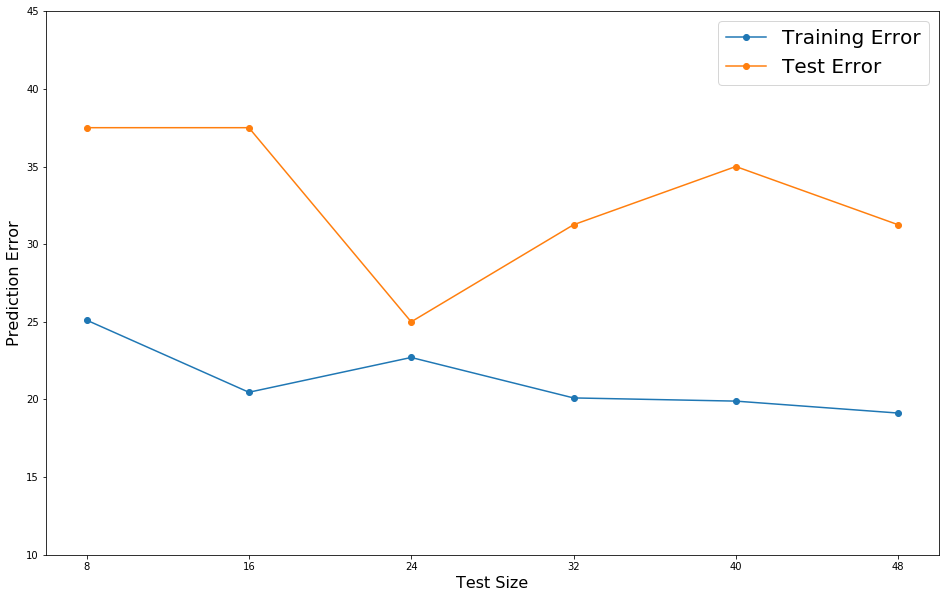

In [57]:
plt.figure(figsize=(16,10))

plt.plot(l, training_results, 'o-', label="Training Error")
plt.plot(l, test_results, 'o-', label="Test Error")

plt.xticks(l) 
plt.yticks(np.arange(10, 50, 5)) 

plt.xlabel("Test Size", fontsize = 16)
plt.ylabel('Prediction Error', fontsize = 16)
plt.legend(prop={'size': 20})

plt.savefig("../Tesi_Pdf/foto/Error.png")
plt.show()

## Exploring parameters

In [58]:
parameters = pd.concat([poisson_model_1.params, poisson_model_2.params, poisson_model_3.params, poisson_model_4.params], axis=1)

In [59]:
parameters

,0,1,2,3
Intercept,1.971484,1.922057,1.745946,1.965627
team[T.BasketGolfoPiombino],0.009355,0.081495,0.014305,-0.232536
team[T.EtruscaBasketSMiniato],-0.125126,-0.183198,-0.104252,-0.335083
team[T.FiorentinaBasketScandicci],0.046981,0.313440,0.152532,0.031905
team[T.FulgorOmegna],-0.011785,0.139677,0.070274,-0.257448
team[T.LibLiburnaBasketLivorno],-0.197386,-0.034826,0.005135,-0.139614
team[T.MontecatiniBasketball],-0.076307,0.221902,0.109181,-0.209463
team[T.OleggioMagicBasket],-0.069979,0.092000,-0.062631,-0.230501
team[T.OlimpoBasketAlba],-0.197170,0.070774,0.027300,-0.123886
team[T.OmniaBasketPavia],-0.042558,0.039521,-0.049618,-0.118566


In [60]:
attack = parameters.iloc[1:16, :].copy()
defense = parameters.iloc[16:-1, :].copy()

#### The Attack Parameter

In [61]:
attack.mean(axis=0)

0   -0.097609
1    0.074418
2   -0.000176
3   -0.201902
dtype: float64

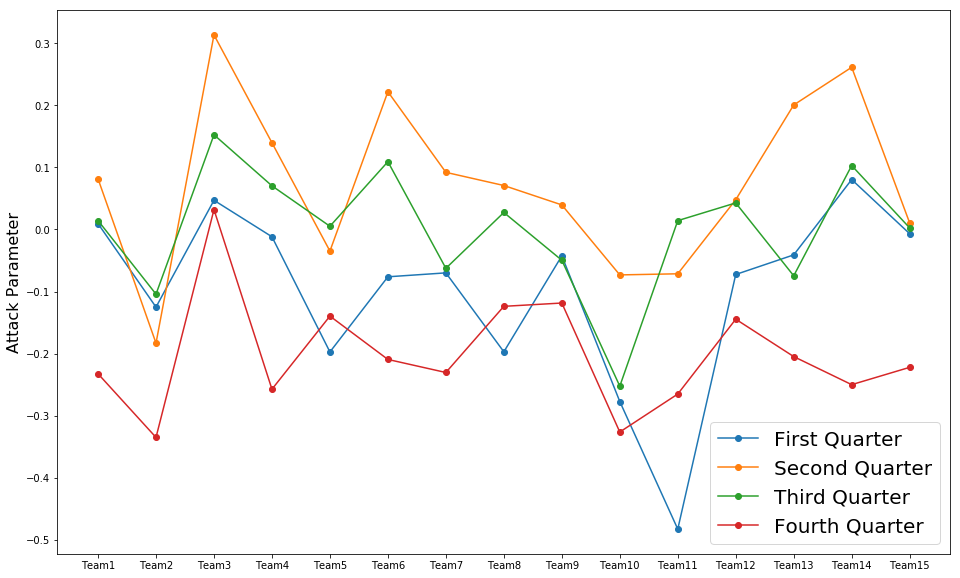

In [62]:
plt.figure(figsize=(16,10))

plt.plot([f"Team{i}" for i in range(1,16)], attack[0], 'o-', label="First Quarter")
plt.plot([f"Team{i}" for i in range(1,16)], attack[1], 'o-', label="Second Quarter")
plt.plot([f"Team{i}" for i in range(1,16)], attack[2], 'o-', label="Third Quarter")
plt.plot([f"Team{i}" for i in range(1,16)], attack[3], 'o-', label="Fourth Quarter")

plt.legend(prop={'size': 20})
plt.ylabel('Attack Parameter', fontsize = 16)

plt.savefig("../Tesi_Pdf/foto/Attack.png")
plt.show()

#### The Defense Parameter

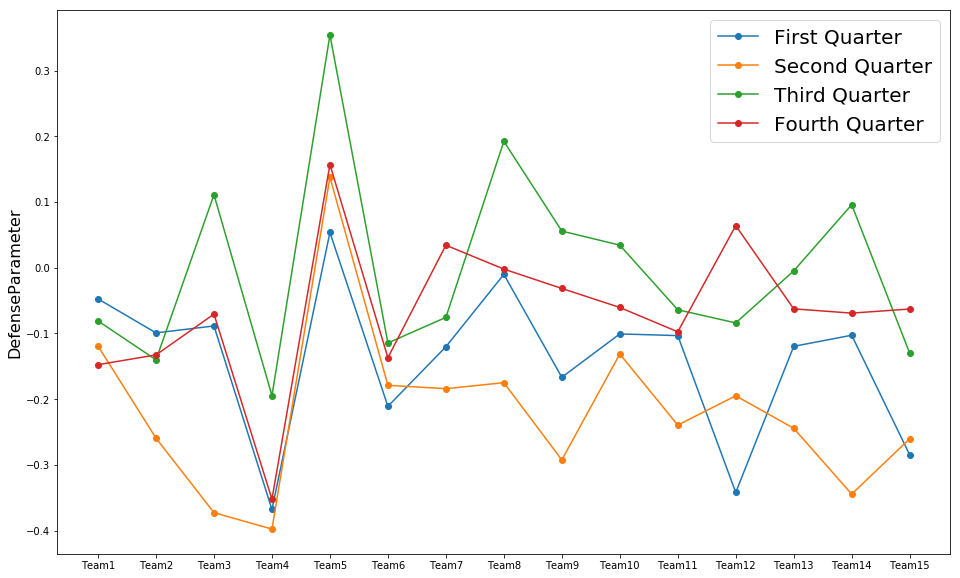

In [63]:
plt.figure(figsize=(16,10))

plt.plot([f"Team{i}" for i in range(1,16)], defense[0], 'o-', label="First Quarter")
plt.plot([f"Team{i}" for i in range(1,16)], defense[1], 'o-', label="Second Quarter")
plt.plot([f"Team{i}" for i in range(1,16)], defense[2], 'o-', label="Third Quarter")
plt.plot([f"Team{i}" for i in range(1,16)], defense[3], 'o-', label="Fourth Quarter")

plt.legend(prop={'size': 20})
plt.ylabel('DefenseParameter', fontsize = 16)

plt.savefig("../Tesi_Pdf/foto/Defense.png")
plt.show()